# Praktyczne zastosowanie modeli oceny wartości relacji z klientem w czasie.

#### Wczytanie bibliotek

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly as py
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from matplotlib.dates import date2num
from matplotlib.lines import Line2D
import plotly.graph_objs as go
from scipy.spatial import ConvexHull
from scipy.stats import zscore
from plotly.offline import init_notebook_mode,iplot
import datetime
import math


#### Konfiguracja

In [179]:
days_pl = ['Poniedziałek', 'Wtorek', 'Środa', 'Czwartek', 'Piątek', 'Niedziela']
months_pl = ['Styczeń', 'Luty', 'Marzec', 'Kwiecień', 'Maj', 'Czerwiec', 'Lipiec', 'Sierpień', 'Wrzesień', 'Październik', 'Listopad', 'Grudzień']
colors = ['#DF2020', '#81DF20', '#2095DF', '#c45200', '#00fff2', '#6f00ff', '#FFB400', '#0D2C54', '#50514F', '#321325', '#9D75CB', '#E6AACE' ] # Kolory dla maks. 6 kategorii

init_notebook_mode(connected=True)

plt.style.use('fivethirtyeight')

#### Wczytanie danych

In [3]:
df = pd.read_csv("./data/data.csv", encoding="ISO-8859-1", dtype={'CustomerID': str,'InvoiceID': str})
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


#### Analiza eksploracyjna danych

***InvoiceNo***: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation. <br>
***StockCode***: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product. <br>
***Description***: Product (item) name. Nominal. <br>
***Quantity***: The quantities of each product (item) per transaction. Numeric. <br>
***InvoiceDate***: Invice Date and time. Numeric, the day and time when each transaction was generated. <br>
***UnitPrice***: Unit price. Numeric, Product price per unit in sterling. <br>
***CustomerID***: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer. <br>
***Country***: Country name. Nominal, the name of the country where each customer resides.

In [4]:
print(f'Liczba wierszy: {df.shape[0]} \nLiczba kolumn: {df.shape[1]}')

Liczba wierszy: 541909 
Liczba kolumn: 8


In [5]:
def summarizeDataframe( dataframe ):
    tab_info=pd.DataFrame(dataframe.dtypes).T.rename(index={0:'Column Type'})
    tab_info=tab_info.append(pd.DataFrame(dataframe.isnull().sum()).T.rename(index={0:'Missing values count'}))
    tab_info=tab_info.append(pd.DataFrame(dataframe.isnull().sum()/dataframe.shape[0]*100).T.
                            rename(index={0:'Percent of missing values'}))
    display(tab_info)

In [6]:
summarizeDataframe(df)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
Column Type,object,object,object,int64,object,float64,object,object
Missing values count,0,0,1454,0,0,0,135080,0
Percent of missing values,0,0,0.268311,0,0,0,24.9267,0


Text(0.5, 1.0, 'Ratio of missing values per columns')

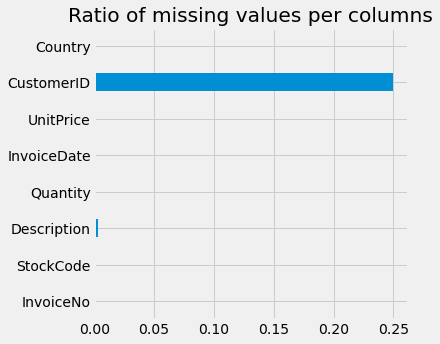

In [7]:
plt.figure(figsize=(5, 5))
df.isna().mean(axis=0).plot.barh()
plt.title("Ratio of missing values per columns")

In [9]:
# Usunięcie obserwacji z brakującym "CustomerID"

df.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
summarizeDataframe(df)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
Column Type,object,object,object,int64,object,float64,object,object
Missing values count,0,0,0,0,0,0,0,0
Percent of missing values,0,0,0,0,0,0,0,0


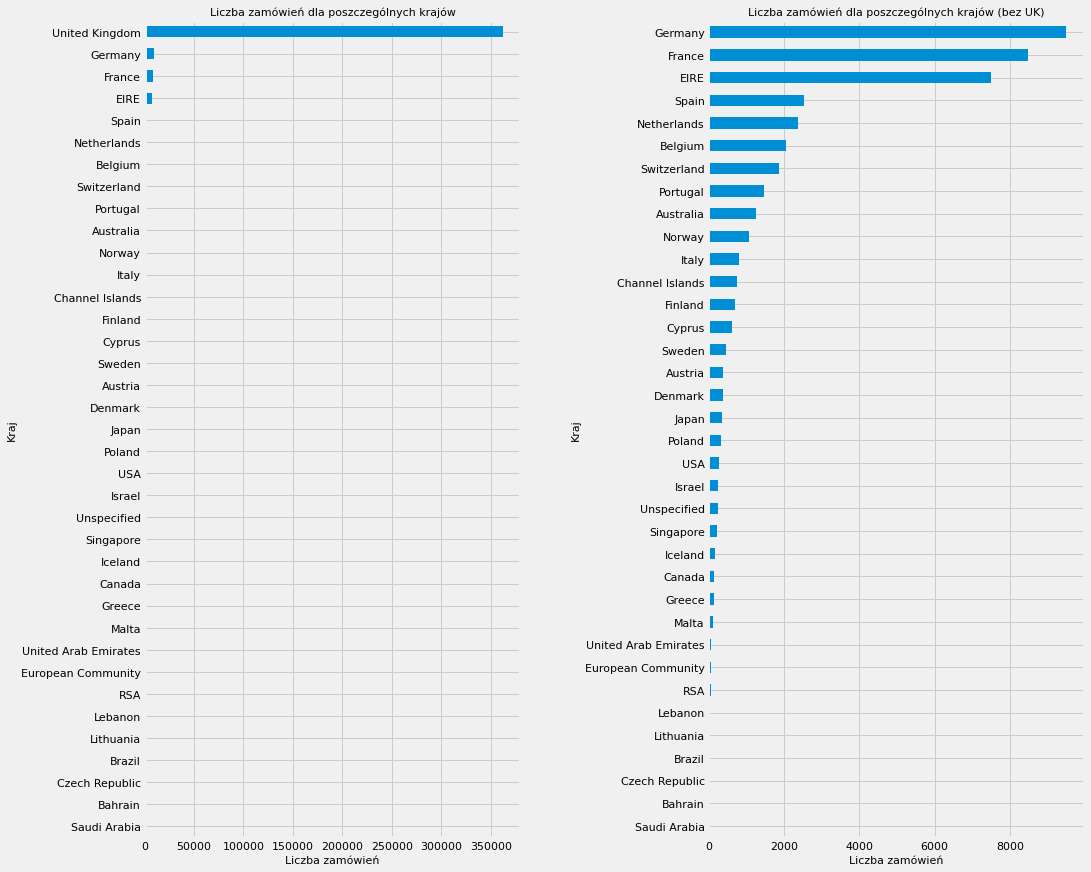

In [10]:
group_country_orders = df.groupby('Country')['InvoiceNo'].count().sort_values()

plt.figure(1 , figsize = (15 , 14))

# plot number of unique customers in each country
plt.subplot(1 , 2 , 1)
plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
group_country_orders.plot(kind='barh', fontsize=11)
plt.xlabel('Liczba zamówień', fontsize=11)
plt.ylabel('Kraj', fontsize=11)
plt.title('Liczba zamówień dla poszczególnych krajów', fontsize=11)

# plot number of unique customers in each country (without UK)
del group_country_orders['United Kingdom']
plt.subplot(1 , 2 , 2)
plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
group_country_orders.plot(kind='barh', fontsize=11)
plt.xlabel('Liczba zamówień', fontsize=11)
plt.ylabel('Kraj', fontsize=11)
plt.title('Liczba zamówień dla poszczególnych krajów (bez UK)', fontsize=11)

plt.show()

In [11]:
df['InvoiceDateFormat']=pd.to_datetime(df['InvoiceDate'], format='%m/%d/%Y %H:%M')

df.drop("InvoiceDayOfWeek", axis=1, errors='ignore', inplace = True)
df.insert(loc = len(df.columns), column='InvoiceDayOfWeek', value=(df.InvoiceDateFormat.dt.day_name()))
df.drop("InvoiceDayOfWeekNumber", axis=1, errors='ignore', inplace = True)
df.insert(loc = len(df.columns), column='InvoiceDayOfWeekNumber', value=(df.InvoiceDateFormat.dt.dayofweek))

df.drop("InvoiceMonth", axis=1, errors='ignore', inplace = True)
df.insert(loc = len(df.columns), column='InvoiceMonth', value=(df.InvoiceDateFormat.dt.month_name()))

df.drop("InvoiceYear", axis=1, errors='ignore', inplace = True)
df.insert(loc = len(df.columns), column='InvoiceYear', value=(df.InvoiceDateFormat.dt.year))

df.drop("InvoiceHour", axis=1, errors='ignore', inplace = True)
df.insert(loc = len(df.columns), column='InvoiceHour', value=(df.InvoiceDateFormat.dt.hour))

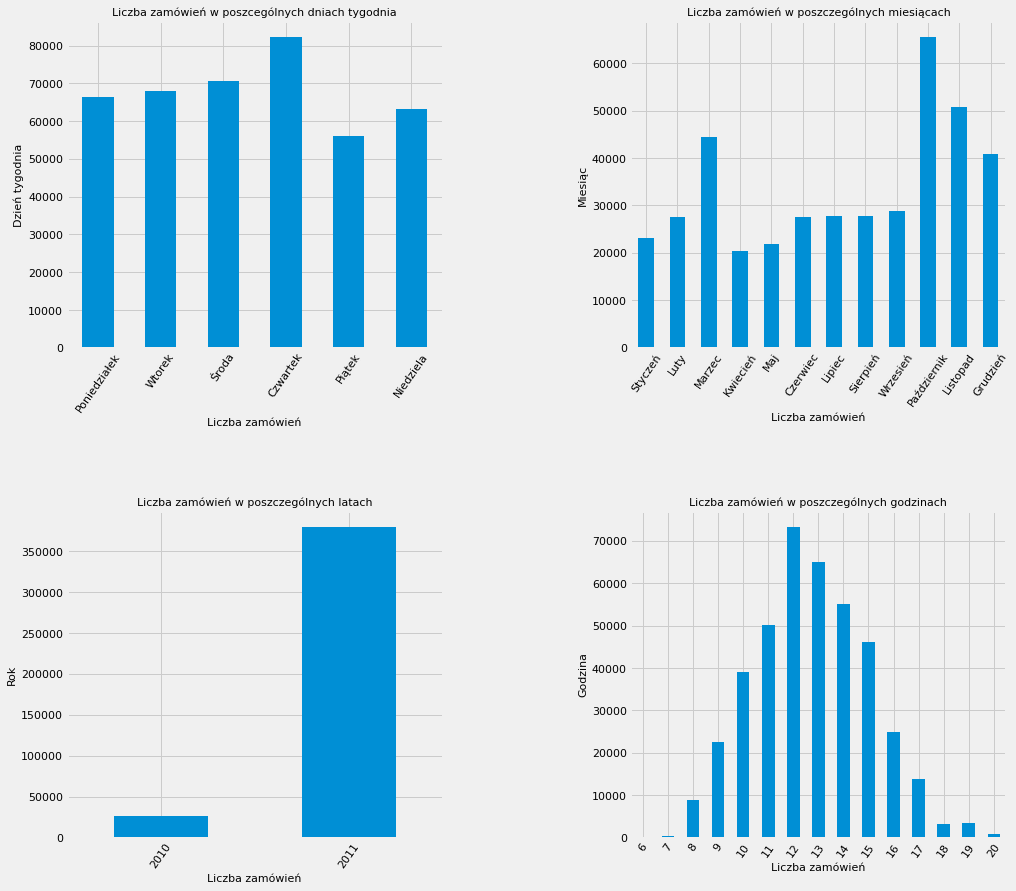

In [12]:
group_day_of_week_orders = df.groupby('InvoiceDayOfWeekNumber')['InvoiceNo'].count().sort_index()
group_month_orders = df.groupby('InvoiceMonth')['InvoiceNo'].count().sort_index()
group_year_orders = df.groupby('InvoiceYear')['InvoiceNo'].count().sort_index()
group_hour_orders = df.groupby('InvoiceHour')['InvoiceNo'].count().sort_index()

plt.figure(1 , figsize = (15 , 14))

# plot number of unique orders in each day of week
plt.subplot(2 , 2 , 1)
plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
group_day_of_week_orders.plot(kind='bar', fontsize=11)
plt.xlabel('Liczba zamówień', fontsize=11)
plt.ylabel('Dzień tygodnia', fontsize=11)
locs, labels = plt.xticks()
plt.xticks(ticks=locs, labels =days_pl, rotation = 55)
plt.title('Liczba zamówień w poszcególnych dniach tygodnia', fontsize=11)

# plot number of unique orders in each month
plt.subplot(2 , 2 , 2)
plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
group_month_orders.plot(kind='bar', fontsize=11)
plt.xlabel('Liczba zamówień', fontsize=11)
plt.ylabel('Miesiąc', fontsize=11)
locs, labels = plt.xticks()
plt.xticks(ticks=locs, labels =months_pl, rotation = 55)
plt.title('Liczba zamówień w poszczególnych miesiącach', fontsize=11)

# plot number of unique orders in each year
plt.subplot(2 , 2 , 3)
plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
group_year_orders.plot(kind='bar', fontsize=11)
plt.xlabel('Liczba zamówień', fontsize=11)
plt.ylabel('Rok', fontsize=11)
plt.xticks(rotation = 55)
plt.title('Liczba zamówień w poszczególnych latach', fontsize=11)

# plot number of unique orders in each hour
plt.subplot(2 , 2 , 4)
plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
group_hour_orders.plot(kind='bar', fontsize=11)
plt.xlabel('Liczba zamówień', fontsize=11)
plt.ylabel('Godzina', fontsize=11)
plt.xticks(rotation = 55)
plt.title('Liczba zamówień w poszczególnych godzinach', fontsize=11)

plt.show()

In [13]:
df.drop("IsInvoiceCancelled", axis=1, errors='ignore', inplace = True)
df['IsInvoiceCancelled'] = df['InvoiceNo'].apply(lambda x: ('C' in x))

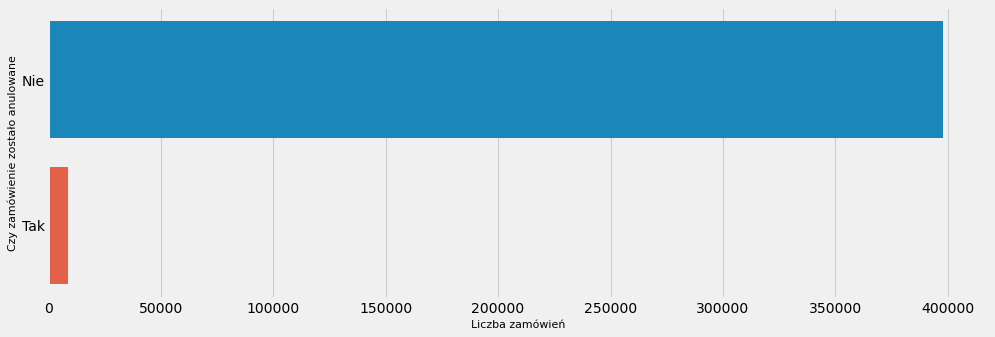

In [14]:
plt.figure(1 , figsize = (15 , 5))
sns.countplot(y = 'IsInvoiceCancelled' , data = df)
plt.xlabel('Liczba zamówień', fontsize=11)
plt.ylabel('Czy zamówienie zostało anulowane', fontsize=11)
locs, labels = plt.yticks()
plt.yticks(ticks=locs, labels = ['Nie', 'Tak'])
plt.show()

In [15]:
df.drop("TotalPrice", axis=1, errors='ignore', inplace = True)
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [16]:
revenue_df = df[['TotalPrice', 'InvoiceDateFormat']]
revenue_df['date'] = revenue_df['InvoiceDateFormat'].apply(lambda x: x.date())
revenue_by_date = revenue_df.groupby('date')['TotalPrice'].sum()

C:\Users\janic\AppData\Local\Temp\ipykernel_22316\90751842.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



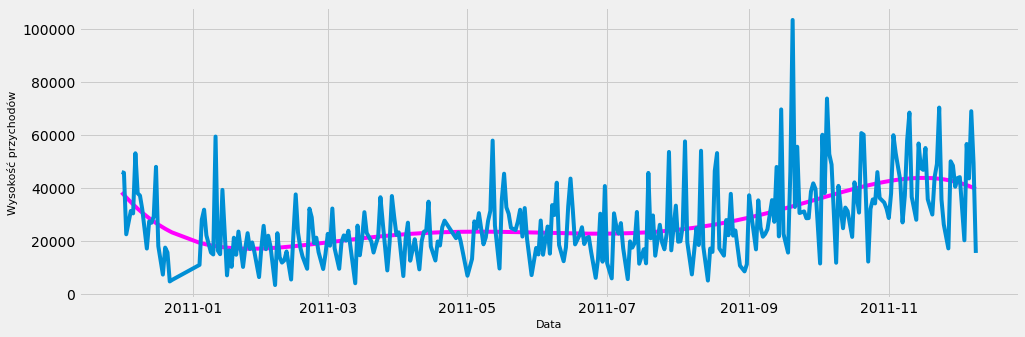

In [17]:
plt.figure(1 , figsize = (15 , 5))
z = np.polyfit(date2num(revenue_by_date.index), revenue_by_date.values, 5)
n = np.poly1d(z)(date2num(revenue_by_date.index))
# plt.plot(date2num(revenue_by_day.index), n)
# plt.plot(revenue_by_day.index, revenue_by_day.values)
sns.lineplot(date2num(revenue_by_date.index), n, color="magenta")
sns.lineplot(revenue_by_date.index, revenue_by_date.values)
plt.ylabel('Wysokość przychodów', fontsize=11)
plt.xlabel('Data', fontsize=11)
plt.show()

In [18]:
revenue_by_day = df.groupby('InvoiceDayOfWeekNumber')['TotalPrice'].sum().sort_index()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



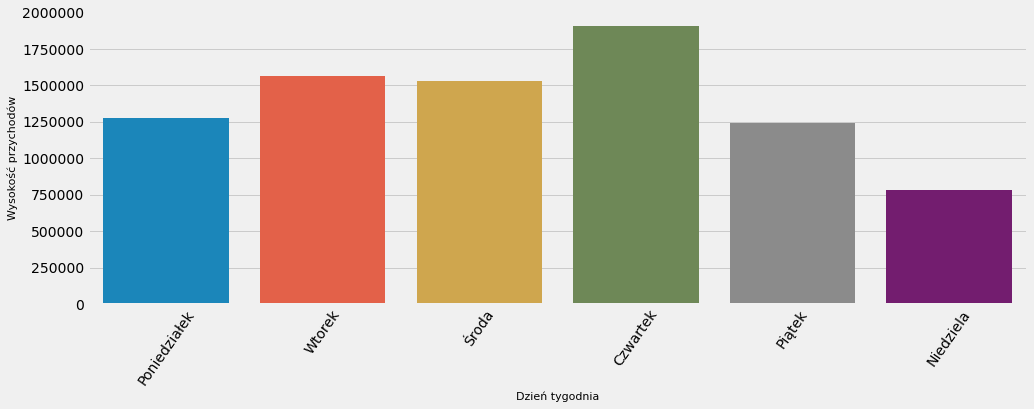

In [19]:
plt.figure(1 , figsize = (15 , 5))
sns.barplot(revenue_by_day.index, revenue_by_day.values)
locs, labels = plt.xticks()
plt.xticks(ticks=locs, labels =days_pl, rotation = 55)
plt.ylabel('Wysokość przychodów', fontsize=11, )
plt.xlabel('Dzień tygodnia', fontsize=11)
plt.ticklabel_format(useOffset = False, style = "plain", axis ='y')
plt.show()

C:\Users\janic\AppData\Local\Temp\ipykernel_22316\1359948194.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Figure size 1080x360 with 0 Axes>

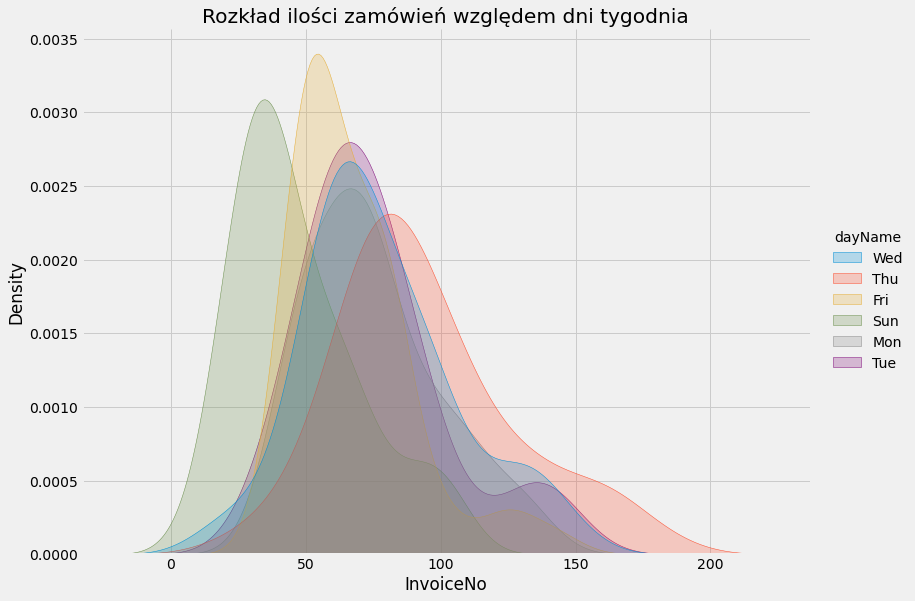

In [20]:
invoice_df = df[['InvoiceDateFormat', 'InvoiceNo']]
invoice_df['date'] = invoice_df['InvoiceDateFormat'].apply(lambda x: x.date())
invoice_count_by_day = invoice_df.groupby('date')['InvoiceNo'].nunique().reset_index()

# summarizeDataframe(invoice_count_by_day)

invoice_count_by_day['dayName'] = invoice_count_by_day['date'].apply(lambda x: x.strftime("%a"))


plt.figure(1 , figsize = (15 , 5))
sns.displot(data=invoice_count_by_day, x="InvoiceNo", fill=True, hue = "dayName", kind = "kde", height=8.27, aspect=11.7/8.27)
plt.title('Rozkład ilości zamówień względem dni tygodnia')
plt.show()

In [21]:
temp = df[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()

data = dict(type='choropleth',
locations = countries.index,
locationmode = 'country names', z = countries,
text = countries.index, colorbar = {'title':'Ilość zamówień'},
colorscale=[[0, '#ffd1d1'],
            [0.005, '#ff9c9c'], [0.02, '#ff9c9c'],
            [1, '#fa0000']],    
reversescale = False)
#_______________________
layout = dict(title='Ilość zamówień w poszczególnych krajach', geo = dict(showframe = True, projection={'type':'equirectangular'}))
#______________
choromap = go.Figure(data = [data], layout = layout)
choromap.update_layout(
    autosize = False,
    width = 1200,
    height = 650
)
iplot(choromap, validate=False)

### Transformacja zmiennych

Tworzenie nowych zmiennych

In [97]:
transformed_df = pd.DataFrame()
transformed_df['CustomerID'] = df['CustomerID'].unique()

total_orders_value = df.groupby('CustomerID')['TotalPrice'].sum().to_frame().rename(columns={'TotalPrice' : 'TotalOrdersValue'})
avg_order_value = df.groupby('CustomerID')['TotalPrice'].mean().to_frame().rename(columns={'TotalPrice' : 'AverageOrderValue'})
orders_count = df.groupby('CustomerID')['InvoiceNo'].nunique().to_frame().rename(columns={'InvoiceNo' : 'OrdersCount'})
min_order_value = df.groupby('CustomerID')['TotalPrice'].min().to_frame().rename(columns={'TotalPrice' : 'MinOrderValue'})
max_order_value = df.groupby('CustomerID')['TotalPrice'].max().to_frame().rename(columns={'TotalPrice' : 'MaxOrderValue'})
cancelled_orders_count = df.groupby('CustomerID')['IsInvoiceCancelled'].sum().to_frame().rename(columns={'IsInvoiceCancelled' : 'CancelledOrdersCount'})
cancelled_orders_value = df[df['IsInvoiceCancelled'] == True].groupby('CustomerID')['TotalPrice'].sum().to_frame().rename(columns={'TotalPrice' : 'CancelledOrdersValue'})
now = datetime.datetime.now()
first_order_datetime = df.groupby('CustomerID')['InvoiceDateFormat'].min()
last_order_datetime = df.groupby('CustomerID')['InvoiceDateFormat'].max()
first_order_datetime = first_order_datetime.to_frame().rename(columns={'InvoiceDateFormat' : 'DaysSinceFirstOrder'})
last_order_datetime = last_order_datetime.to_frame().rename(columns={'InvoiceDateFormat' : 'DaysSinceLastOrder'})
days_since_first_order = (now - first_order_datetime['DaysSinceFirstOrder']).dt.days
days_since_last_order = (now - last_order_datetime['DaysSinceLastOrder']).dt.days
avg_quantity = df.groupby('CustomerID')['Quantity'].mean().to_frame().rename(columns={'Quantity' : 'AverageQuantity'})
most_freq_order_day = df.groupby('CustomerID')['InvoiceDayOfWeekNumber'].agg(lambda x:x.value_counts().index[0]).to_frame().rename(columns={'InvoiceDayOfWeekNumber' : 'MostFreqOrderDay'})
most_freq_order_hour = df.groupby('CustomerID')['InvoiceHour'].agg(lambda x:x.value_counts().index[0]).to_frame().rename(columns={'InvoiceHour' : 'MostFreqOrderHour'})

transformed_df = transformed_df.merge(total_orders_value, how="inner", on="CustomerID")
transformed_df = transformed_df.merge(avg_order_value, how="inner", on="CustomerID")
transformed_df = transformed_df.merge(orders_count, how="inner", on="CustomerID")
transformed_df = transformed_df.merge(min_order_value, how="inner", on="CustomerID")
transformed_df = transformed_df.merge(max_order_value, how="inner", on="CustomerID")
transformed_df = transformed_df.merge(cancelled_orders_count, how="inner", on="CustomerID")
transformed_df = transformed_df.merge(cancelled_orders_value, how="left", on="CustomerID")
transformed_df = transformed_df.merge(days_since_first_order, how="inner", on="CustomerID")
transformed_df = transformed_df.merge(days_since_last_order, how="inner", on="CustomerID")
transformed_df = transformed_df.merge(avg_quantity, how="inner", on="CustomerID")
transformed_df = transformed_df.merge(most_freq_order_day, how="inner", on="CustomerID")
transformed_df = transformed_df.merge(most_freq_order_hour, how="inner", on="CustomerID")
transformed_df['CancelledOrdersValue'] = transformed_df['CancelledOrdersValue'].fillna(0)

In [98]:
# Badanie skośności zmiennych
transformed_df_skewness = transformed_df.skew(axis=0)
display(transformed_df_skewness)

CustomerID               0.000918
TotalOrdersValue        21.705287
AverageOrderValue        2.441509
OrdersCount             11.412274
MinOrderValue          -50.903961
MaxOrderValue           50.546771
CancelledOrdersCount    13.035417
CancelledOrdersValue   -47.414696
DaysSinceFirstOrder     -0.388254
DaysSinceLastOrder       1.249370
AverageQuantity         48.886768
MostFreqOrderDay         0.383756
MostFreqOrderHour        0.144354
dtype: float64

Standaryzacja i usuwanie skośności zmiennych za pomocą logarytmowania

In [99]:
for column in transformed_df:
    skewness = transformed_df_skewness[column]
    if skewness > 0.5:
        transformed_df[f'{column}Norm'] = np.log(transformed_df[column] - np.min(transformed_df[column]) + 1)
    if skewness < -0.5:        
        transformed_df[f'{column}Norm'] = np.power(transformed_df[column], 3)

# transformed_df['AverageOrderValueZscore'] = zscore(transformed_df['AverageOrderValue'])
# transformed_df['AverageOrderValueLog'] = np.log(transformed_df['AverageOrderValueZscore'] - np.min(transformed_df['AverageOrderValueZscore']) + 1)


In [102]:
transformed_df_skewness = transformed_df.skew(axis=0)
display(transformed_df_skewness)

CustomerID                   0.000918
TotalOrdersValue            21.705287
AverageOrderValue            2.441509
OrdersCount                 11.412274
MinOrderValue              -50.903961
MaxOrderValue               50.546771
CancelledOrdersCount        13.035417
CancelledOrdersValue       -47.414696
DaysSinceFirstOrder         -0.388254
DaysSinceLastOrder           1.249370
AverageQuantity             48.886768
MostFreqOrderDay             0.383756
MostFreqOrderHour            0.144354
TotalOrdersValueNorm         0.266272
AverageOrderValueNorm      -63.220479
OrdersCountNorm              0.681305
MinOrderValueNorm          -65.257256
MaxOrderValueNorm          -27.775828
CancelledOrdersCountNorm     1.739134
CancelledOrdersValueNorm   -65.252858
DaysSinceLastOrderNorm      -0.447053
AverageQuantityNorm          4.170847
dtype: float64

### Klastryzacja

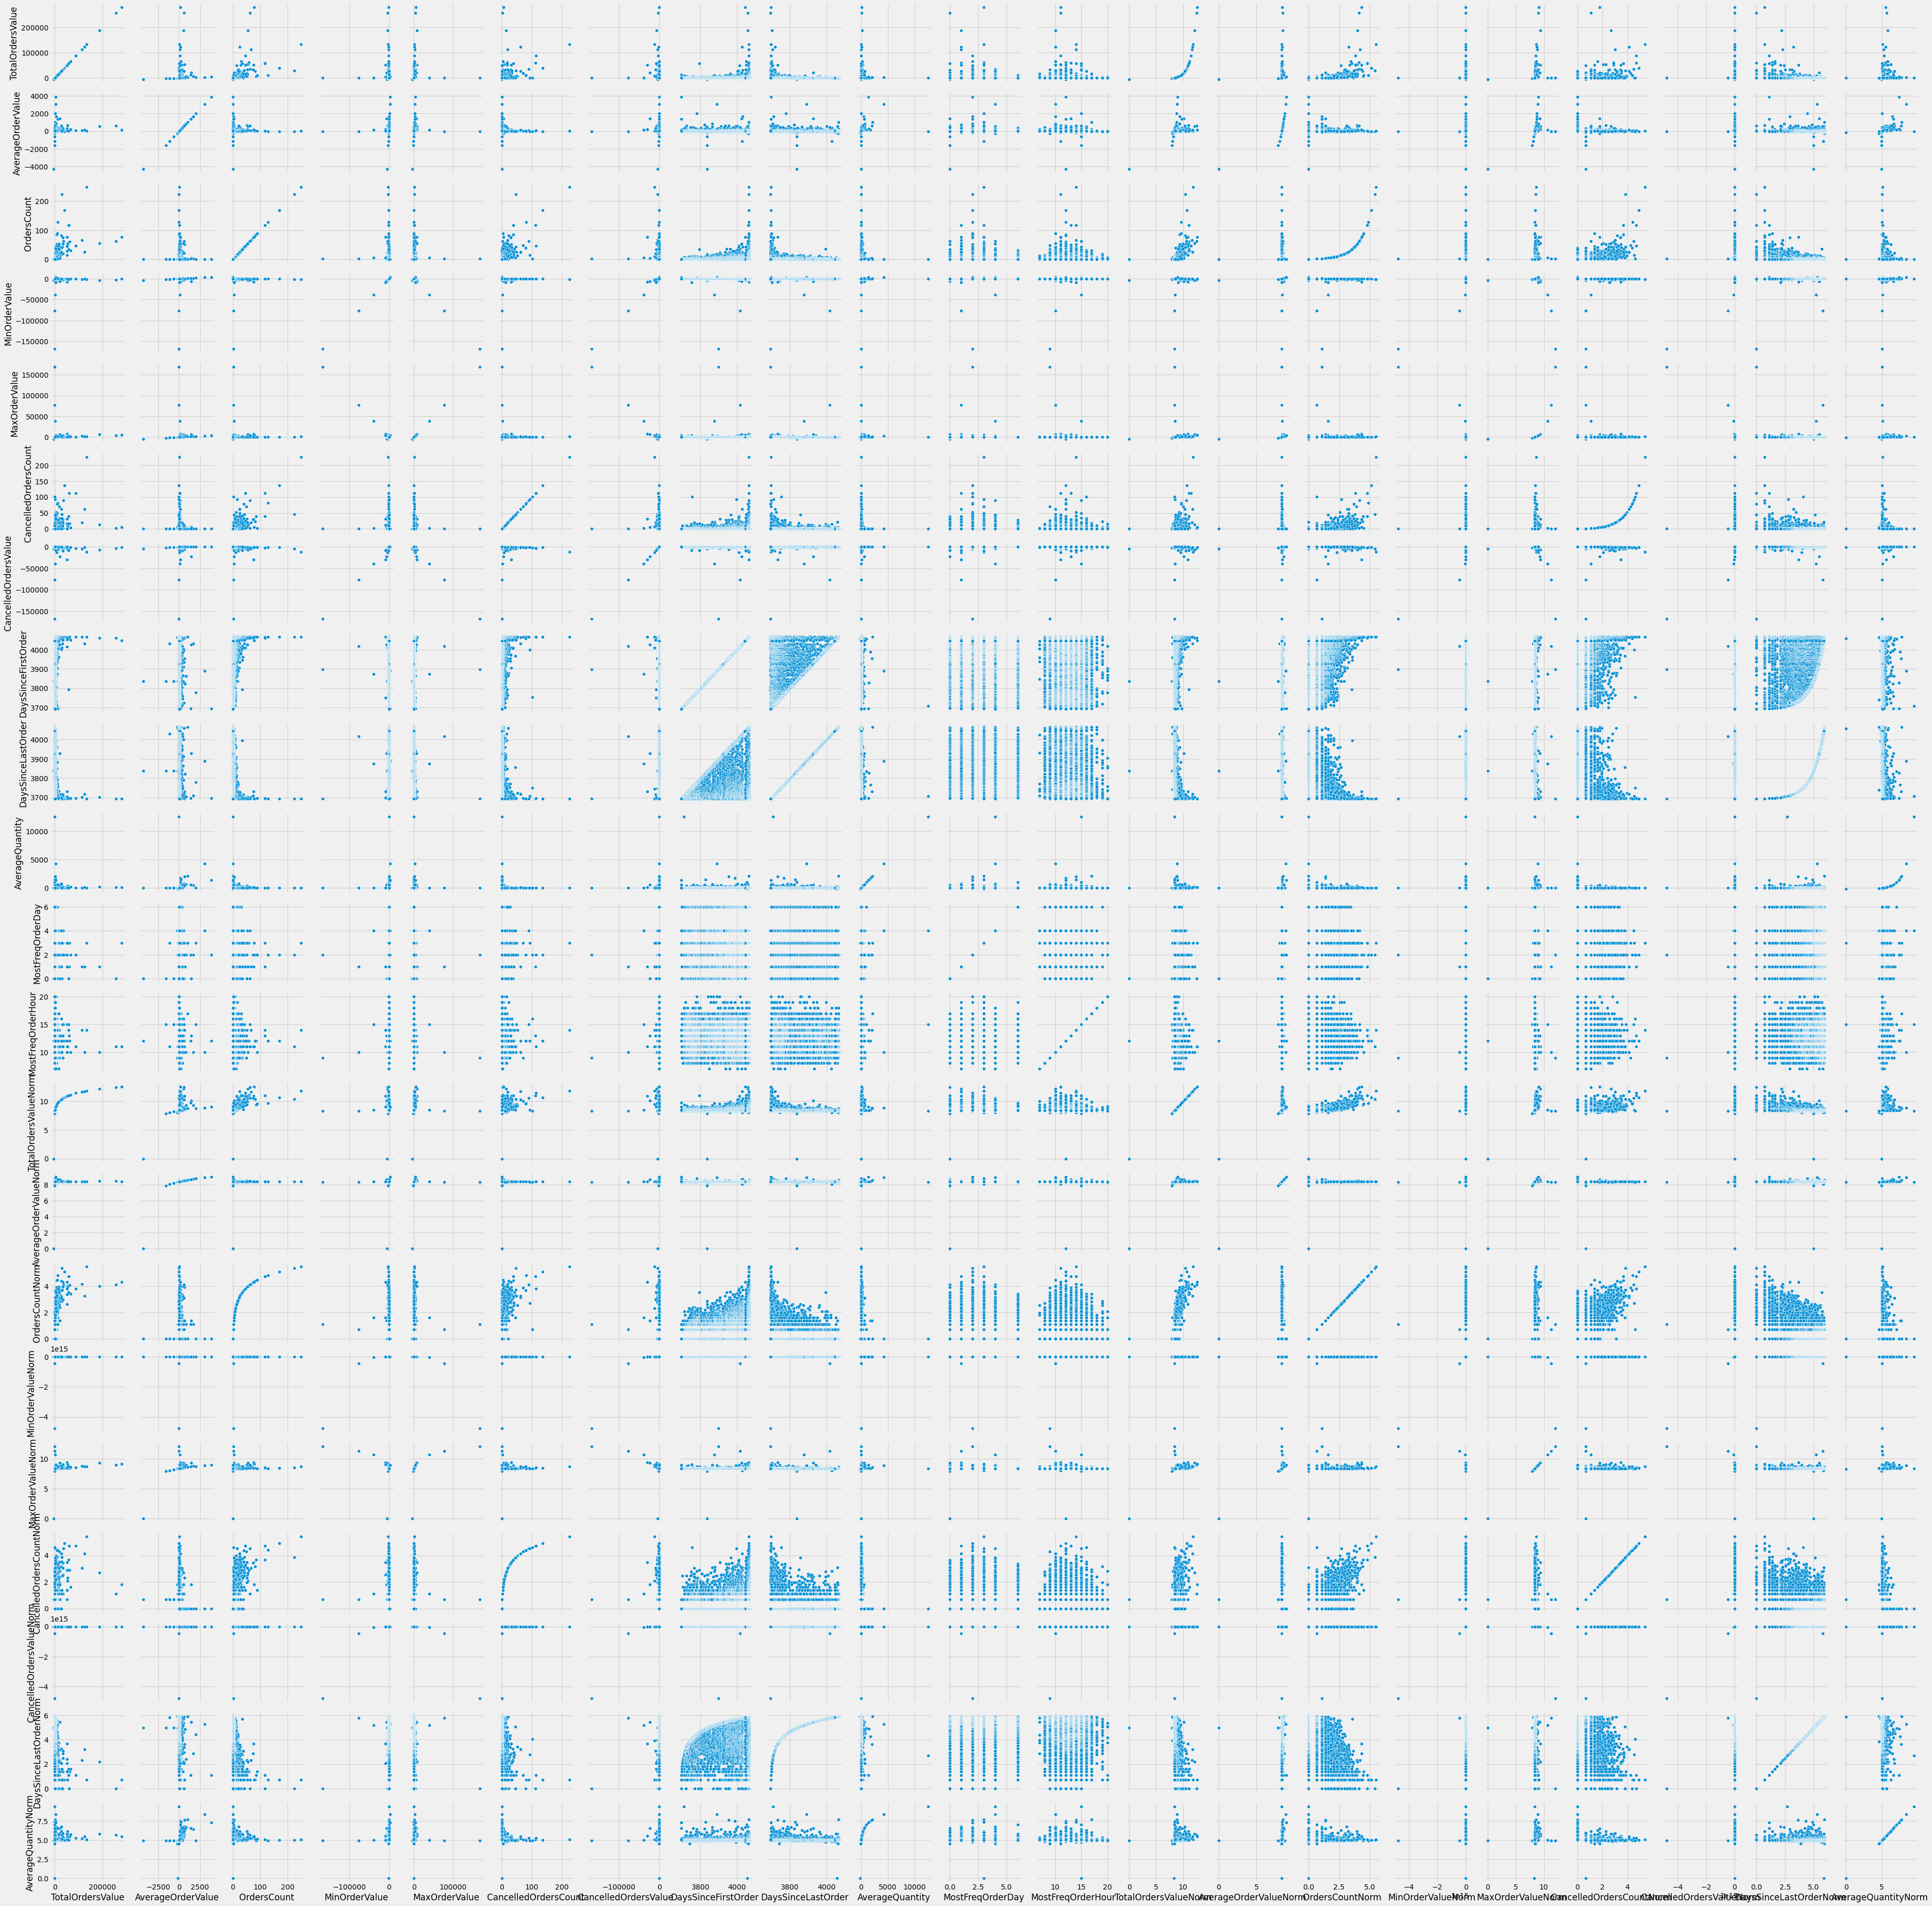

In [101]:
g = sns.PairGrid(transformed_df)
g.map(sns.scatterplot)

In [231]:
# Selekcja zmiennych, na podstawie których wykonana zostanie klasteryzacja

#1
# variable_pair = ['TotalOrdersValueNorm', 'MaxOrderValueNorm']
# df_for_clustering = transformed_df[[variable_pair[0], variable_pair[1]]]

#2
# variable_pair = ['AverageOrderValue', 'OrdersCountNorm']
# df_for_clustering = transformed_df[[variable_pair[0], variable_pair[1]]]

#3
# variable_pair = ['MostFreqOrderHour', 'TotalOrdersValueNorm']
# df_for_clustering = transformed_df[[variable_pair[0], variable_pair[1]]]

#4
variable_pair = ['CancelledOrdersCount', 'OrdersCount']
df_for_clustering = transformed_df[[variable_pair[0], variable_pair[1]]]

In [232]:
# Detekcja wartości odstających

def detectOutliers(variable_pair, dataframe):
    var1 = variable_pair[0]
    var2 = variable_pair[1]
    dataframe.drop("outlier", axis=1, errors='ignore', inplace = True)
    
    quartile_1_var1, quartile_3_var1 = np.percentile(dataframe[var1], [25, 75])
    iqr_var1 = quartile_3_var1 - quartile_1_var1
    lower_bound_var1 = quartile_1_var1 - (iqr_var1 * 1.5)
    upper_bound_var1 = quartile_3_var1 + (iqr_var1 * 1.5)
    print(lower_bound_var1, upper_bound_var1)

    quartile_1_var2, quartile_3_var2 = np.percentile(dataframe[var2], [25, 75])
    iqr_var2 = quartile_3_var2 - quartile_1_var2
    lower_bound_var2 = quartile_1_var2 - (iqr_var2 * 1.5)
    upper_bound_var2 = quartile_3_var2 + (iqr_var2 * 1.5)
    print(lower_bound_var2, upper_bound_var2)
    i=0
    while i<=len(dataframe)-1:
        if dataframe.loc[i,var1]> upper_bound_var1:
            dataframe.loc[i,'outlier1']=1
        elif dataframe.loc[i,var1]< lower_bound_var1:
            dataframe.loc[i,'outlier1']=1
        else:
            dataframe.loc[i,'outlier1']=0

        if dataframe.loc[i,var2]> upper_bound_var2:
            dataframe.loc[i,'outlier2']=1
        elif dataframe.loc[i,var2]< lower_bound_var2:
            dataframe.loc[i,'outlier2']=1
        else:
            dataframe.loc[i,'outlier2']=0
        
        
        i=i+1
    return dataframe

df_for_clustering = detectOutliers(variable_pair, df_for_clustering)
df_for_clustering = df_for_clustering.drop(df_for_clustering[df_for_clustering['outlier1'] == 1].index).reset_index()
df_for_clustering = df_for_clustering.drop(df_for_clustering[df_for_clustering['outlier2'] == 1].index).reset_index()

df_for_clustering = df_for_clustering[variable_pair]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

-1.5 2.5
-5.0 11.0


In [233]:
df_for_clustering_skewness = df_for_clustering.skew(axis=0)
display(df_for_clustering_skewness)

CancelledOrdersCount    1.941310
OrdersCount             1.504796
dtype: float64

In [234]:
clustering_matrix = df_for_clustering.iloc[: , :].values

In [240]:
def findBestN(matrix):
    silhouette_values = pd.DataFrame( columns=['ClusterCount', 'SilhouetteValue'])
    for n in range(3,30):
        kmeans = KMeans(n_clusters = n, n_init=20, random_state=0 )
        kmeans.fit(matrix)
        clusters = kmeans.predict(matrix)
        silhouette_avg = silhouette_score(matrix, clusters)
        silhouette_values = silhouette_values.append({'ClusterCount': n, 'SilhouetteValue': silhouette_avg}, ignore_index = True)
    return silhouette_values

In [241]:
# Wyznaczenie wartości współczynnika Silhouette'a

silhouette_values = findBestN(clustering_matrix)

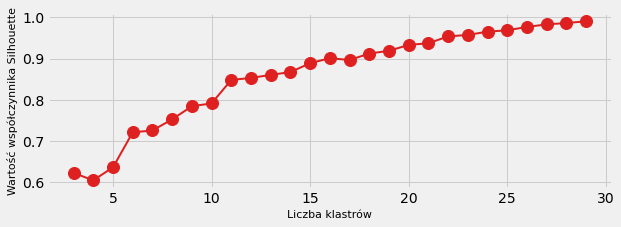

In [242]:
# Wykres wartości wspołczynnika Silhouette'a dla poszczególnej liczby klastrów

plt.figure(1 , figsize = (9 , 3) )
plt.plot(silhouette_values['ClusterCount'], silhouette_values['SilhouetteValue'], marker='o', linestyle='-', linewidth=2, markersize=12)
plt.ylabel('Wartość współczynnika Silhouette', fontsize=11, )
plt.xlabel('Liczba klastrów', fontsize=11)
plt.show()

In [226]:
# Klasteryzacja metodą K-means

best_cluster_count = 4
algorithm = (KMeans(n_clusters = best_cluster_count ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 31  , algorithm='elkan') )
algorithm.fit(clustering_matrix)
labels = algorithm.labels_
centroids = algorithm.cluster_centers_

In [227]:
# Dodanie kolumy definiującej klaster, do którego przypisana została obserwacja

temp = []
for label in labels:
    temp.append([int(label)])
clustering_matrix = np.append(clustering_matrix, temp, axis=1)
df_for_clustering = pd.DataFrame(clustering_matrix, columns=[variable_pair[0], variable_pair[1], 'cluster'])

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning:

Dataset has 0 variance; skipping density estimate.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning:

Dataset has 0 variance; skipping density estimate.



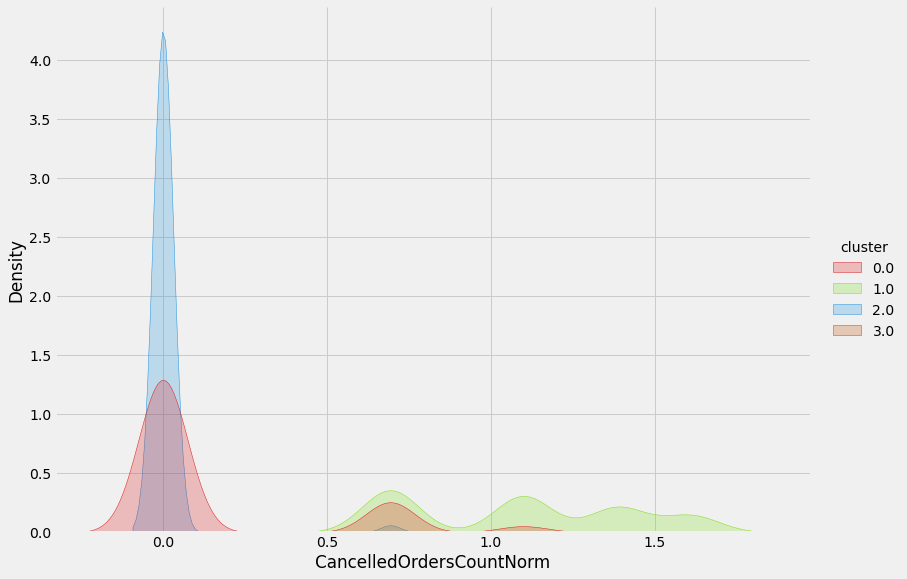

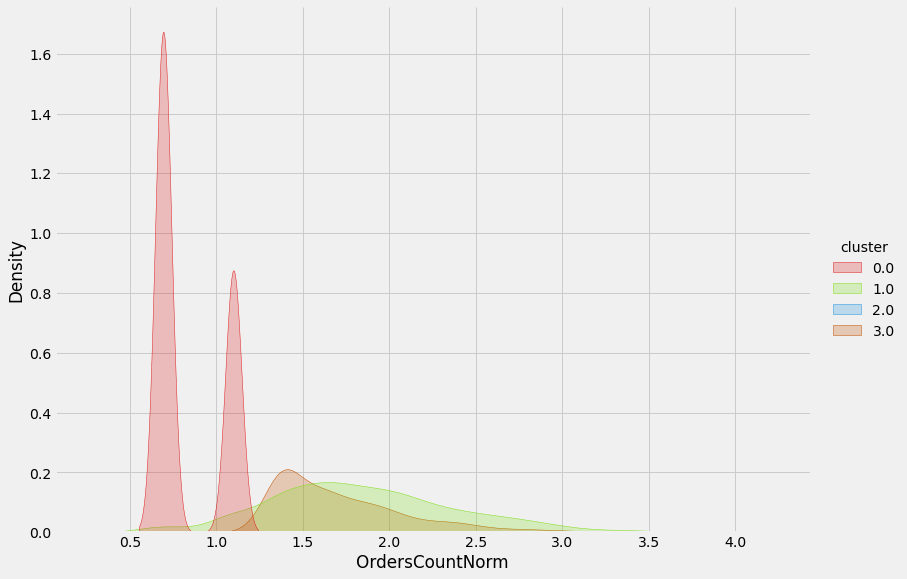

In [228]:
sns.set_palette(sns.color_palette(colors))
sns.displot(data=df_for_clustering, x=variable_pair[0], fill=True, hue = 'cluster' ,kind = "kde", height=8.27, aspect=11.7/8.27, palette=colors[:best_cluster_count])
sns.displot(data=df_for_clustering, x=variable_pair[1], fill=True, hue = 'cluster',kind = "kde", height=8.27, aspect=11.7/8.27, palette=colors[:best_cluster_count])

In [229]:
step = 0.02
x_min, x_max = clustering_matrix[:, 0].min() - 1, clustering_matrix[:, 0].max() + 1
y_min, y_max = clustering_matrix[:, 1].min() - 1, clustering_matrix[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))
Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])

QhullError: QH6013 qhull input error: input is less than 2-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 327717296  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 2.3  Error-roundoff 2.5e-15  _one-merge 1.2e-14
  _near-inside 6.1e-14  Visible-distance 4.9e-15  U-max-coplanar 4.9e-15
  Width-outside 9.8e-15  _wide-facet 2.9e-14  _maxoutside 1.5e-14


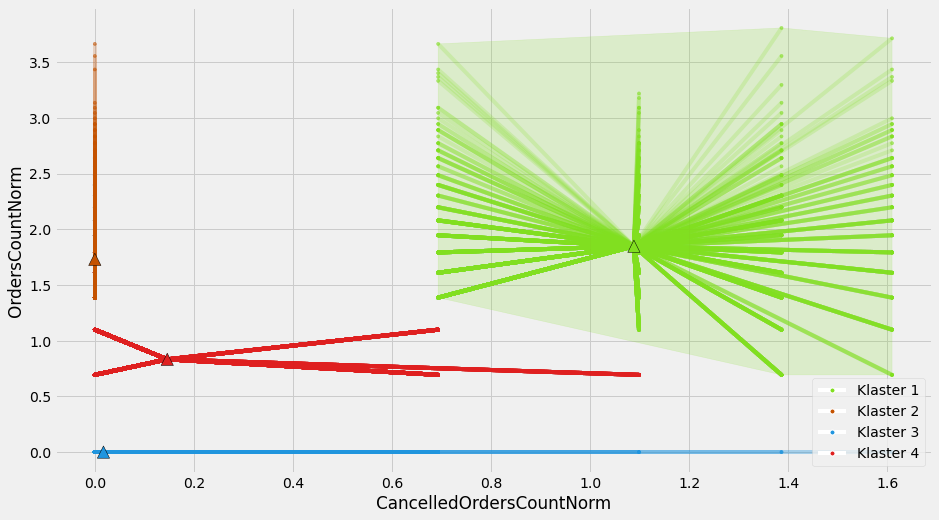

In [230]:
cen_x = [i[0] for i in centroids] 
cen_y = [i[1] for i in centroids]

# Mapowanie kolorów
df_for_clustering['c'] = df_for_clustering.cluster.map({0:colors[0], 1:colors[1], 2:colors[2], 3:colors[3], 4:colors[4], 5:colors[5], 6:colors[6], 7:colors[7], 8:colors[8], 9:colors[9], \
    10:colors[10], 11:colors[11]})

fig, ax = plt.subplots(1, figsize=(14,8))
ax.set_ylabel(variable_pair[1])
ax.set_xlabel(variable_pair[0])

# Punkty
plt.scatter(df_for_clustering[variable_pair[0]], df_for_clustering[variable_pair[1]], c=df_for_clustering.c, alpha = 0.6, s=10)

# Centra klastrów
plt.scatter(cen_x, cen_y, marker='^', c=colors[:len(df_for_clustering['c'].unique())], s=150, edgecolors='black', zorder=100)


# Linie
for idx, val in df_for_clustering.iterrows():
    x = [val[variable_pair[0]], cen_x[int(val['cluster'])],]
    y = [val[variable_pair[1]], cen_y[int(val['cluster'])]]
    plt.plot(x, y, c=val.c, alpha=0.2)

# Legenda
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Klaster {}'.format(i+1), 
               markerfacecolor=mcolor, markersize=5) for i, mcolor in enumerate(df_for_clustering['c'].unique())]
plt.legend(handles=legend_elements, loc='best')

# Obszar klastra
for i in df_for_clustering.cluster.unique():
    points = df_for_clustering[df_for_clustering.cluster == i][[variable_pair[0], variable_pair[1]]].values
    hull = ConvexHull(points)
    x_hull = np.append(points[hull.vertices,0],
                       points[hull.vertices,0][0])
    y_hull = np.append(points[hull.vertices,1],
                       points[hull.vertices,1][0])
    plt.fill(x_hull, y_hull, alpha=0.18, c=colors[int(i)])